# Fake data generator

**for DB lab work №3**

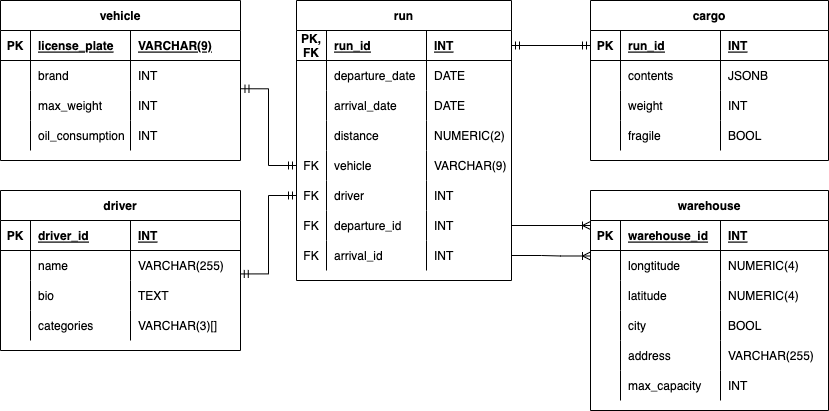

In [26]:
import numpy as np
from tqdm.notebook import tqdm
from faker import Faker
import os
import csv
import random
# from geopy.distance import geodesic
import json

In [27]:
class Logistics:
    def __init__(self):
        pass
    
    # Общая функция, предназначенная для вызова извне, для создания всех таблиц
    # После вызова создает в переданной директории папку "lw3_tables" с необходимыми csv файлами
    def generate_csv(self, vehicle_size, driver_size, warehouse_size, run_size, cargo_size, output_path='.'):
        sizes = [vehicle_size, driver_size, warehouse_size, run_size, cargo_size]
        
        generators = [self._gen_vehicle, self._gen_driver, self._gen_warehouse, self._gen_run, self._gen_cargo]
        
        if not os.path.exists(output_path + 'lw3_tables'):
            os.mkdir(output_path + 'lw3_tables')
        
        # В этих переменных хранятся данные для синхронизации значений, типа внешних ключей и координат
        # для расчета расстояния. Они не имеют единого формата, использовать осторожно.
        self.vehicle = []     # Номер машины и максимальная грузоподъемность
        self.driver = []      # Номер водителя
        self.warehouse = []   # Номер склада и его координаты
        self.run = []         # Номер рейса
        
        for gen, size in tqdm(list(zip(generators, sizes)), desc='Tables generated'):
            gen(int(size), output_path + 'lw3_tables/')
    
    # Каждая из последующих функций создает отдельную таблицу
    # Для поддержания согласованности данных в конце выполнения функция сохраняет самые важные данные,
    # например, внешние ключи или максимальную вместительность транспорта.
    def _gen_vehicle(self, size, output):
        
        # Создание или очистка файла для записи.
        # Необходимо очищать все файлы при каждом запуске, для поддержания связи между таблицами
        file_path = output + 'vehicle.csv'
        file = open(file_path, 'w')
        file.close()
        
        fake = Faker()
        
        with open(file_path, 'a') as file:
            writer = csv.writer(file, delimiter=',')
            writer.writerow(['license_plate', 'brand', 'max_weight', 'oil_consumption'])
            
            brands = ['Ford', 'Mercedes', 'Freightliner', 'BelAZ', 'Citroën', 'Tesla', 'Chevrolet', 'Audi', 'Volkswagen', 'Fiat', 'Astra', 'Robur', 'Ural', 'Kamaz', 'Bristol', 'Star', 'Vulcan']
            
            for _ in tqdm(range(size), desc='Vehicle table'):
                row = [
                    fake.license_plate(),
                    random.choices(brands, k=1)[0],
                    random.randint(2, 300) * 100,
                    int(np.random.normal(50, 15, size=1)[0])
                ]
                
                self.vehicle.append({'license_plate': row[0], 'max_weight': row[2]})
                writer.writerow(row)
    
    def _gen_driver(self, size, output):
        
        # Create or empty existing file
        file_path = output + 'driver.csv'
        file = open(file_path, 'w')
        file.close()
        
        fake = Faker()
        
        with open(file_path, 'a') as file:
            writer = csv.writer(file, delimiter=',')
            writer.writerow(['driver_id', 'name', 'bio', 'categories'])
            
            dr_id = 100_000
            categories = ['"B"', '"BE"', '"C"', '"CE"', '"D"', '"C1"', '"CE1"']
            
            for _ in tqdm(range(size), desc='Driver table'):
                row = [
                    dr_id,
                    fake.name(),
                    fake.paragraph(nb_sentences=5),
                    '[' + ', '.join(random.choices(categories, k=random.randint(1, 3))) + ']'
                ]
                self.driver.append(dr_id)
                dr_id += 1
                
                writer.writerow(row)
    
    def _gen_warehouse(self, size, output):
        
        # Create or empty existing file
        file_path = output + 'warehouse.csv'
        file = open(file_path, 'w')
        file.close()
        
        fake = Faker()
        
        with open(file_path, 'a') as file:
            writer = csv.writer(file, delimiter=',')
            writer.writerow(['warehouse_id', 'latitude', 'longtitude', 'city', 'address', 'max_capacity'])
            
            wh_id = 10000
            top_left_corner = [48.546323, -121.287540]
            bottom_right_corner = [32.436401, -81.209415]
            
            for _ in tqdm(range(size), desc='Warehouse table'):
                place = fake.local_latlng()
                
                row = [
                    wh_id,
                    place[0],                  # latitude
                    place[1],                  # longtitude
                    place[4].split('/')[-1],   # city
                    place[2],                  # address
                    random.randint(1, 5) * 10_000
                ]
                self.warehouse.append({
                    'warehouse_id': row[0],
                    'latitude': row[1],
                    'longtitude': row[2]
                })
                wh_id += 1
                
                writer.writerow(row)
    
    def _gen_run(self, size, output):
        
        # Create or empty existing file
        file_path = output + 'run.csv'
        file = open(file_path, 'w')
        file.close()
        
        fake = Faker()
        
        with open(file_path, 'a') as file:
            writer = csv.writer(file, delimiter=',')
            writer.writerow(['run_id', 'departure_date', 'arrival_date', 'distance', 'vehicle', 'driver', 'departure_id', 'arrival_id'])
    
            run_id = 1_000_000_000
            
            for _ in tqdm(range(size), desc='Run table'):
                
                # Предварительные данные
                base_date = np.datetime64('1960-01-01')
                departure_date = random.randint(0, 365*60) + base_date
                wh = random.choices(self.warehouse, k=2)
#                 distance = int(geodesic([wh[0]['latitude'], wh[0]['longtitude']], [wh[1]['latitude'], wh[1]['longtitude']]).km)
                distance = random.randint(200, 5000)
                arrival_date = departure_date + int(distance // np.random.normal(800, 100, size=1)[0])
                vehicle = random.choices(self.vehicle, k=1)[0]
                
                row = [
                    run_id,
                    departure_date,
                    arrival_date,
                    distance,
                    vehicle['license_plate'],
                    random.choices(self.driver, k=1)[0],
                    wh[0]['warehouse_id'],
                    wh[1]['warehouse_id']
                ]
#                 row = [1, 2, 3, 4, 5, 6, 7, 8]
                
                self.run.append({'run_id': run_id, 'max_weight': vehicle['max_weight']})
                
                run_id += 1
                
                writer.writerow(row)
                
            self.run = np.array(self.run)
    
    def _gen_cargo(self, size, output):
        
        # Create or empty existing file
        file_path = output + 'cargo.csv'
        file = open(file_path, 'w')
        file.close()
        
        fake = Faker()
        
        # Pre-generated data
        people = []
        with open('/Users/mikhail_ovakimyan/Documents/Программирование/responsibles.txt', 'r') as file:
            reader = csv.reader(file)
            for name, phone in reader:
                people.append([name, phone])
                
        companies = []
        with open('/Users/mikhail_ovakimyan/Documents/Программирование/companies.txt', 'r') as file:
            reader = csv.reader(file)
            for c in reader:
                companies.append(c)            
            
        with open(file_path, 'a') as file:
            writer = csv.writer(file, delimiter=',')
            writer.writerow(['run_id', 'contacts', 'weight', 'fragile'])
                
            run_id = 1_000_000_000
            
            for i in tqdm(range(size), desc='Cargo table'):
                
                person = random.choice(people)
                contacts = json.dumps(
                    {'Responsible': {'Name': person[0], 'Phone': person[1]}, 'Reciever': random.choice(companies)}
                )
    
                max_weight = self.run[i]['max_weight']
                
                row = [
                    run_id,
                    contacts,
                    random.randint(int((max_weight // 100) * .8), max_weight // 100) * 100,
                    str(np.random.choice([True, False], size=1, p=[.25, .75])[0]).upper()
                ]
                
                run_id += 1
                
                writer.writerow(row)

In [28]:
db_creator = Logistics()
db_creator.generate_csv(1e6, 3e6, 5e6, 1e8, 1e8, "/Users/mikhail_ovakimyan/Documents/Программирование/")

Tables generated:   0%|          | 0/5 [00:00<?, ?it/s]

Vehicle table:   0%|          | 0/1000000 [00:00<?, ?it/s]

Driver table:   0%|          | 0/3000000 [00:00<?, ?it/s]

Warehouse table:   0%|          | 0/5000000 [00:00<?, ?it/s]

Run table:   0%|          | 0/100000000 [00:00<?, ?it/s]

Cargo table:   0%|          | 0/100000000 [00:00<?, ?it/s]